In [1]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.keys import Keys
import requests
import pyperclip
import time
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False   

pd.set_option('display.width', 1000)

from wordcloud import WordCloud
from konlpy.tag import Okt

## 네이버 웹툰 제목, 링크 크롤링

In [2]:
# 크롬 드라이버 옵션 설정 : 창 최대화
options = webdriver.ChromeOptions()
options.add_argument('--start-maximized')


# 네이버 로그인
browser = webdriver.Chrome('chromedriver.exe',options = options)
browser.get('https://nid.naver.com/nidlogin.login?mode=form&url=https%3A%2F%2Fwww.naver.com')
time.sleep(4)
id= ''
pw = ''

# 18세 이용가 웹툰 크롤링 시 로그인 필요 
# selenium.webdriver의 send.keys() 이용해 id, pw 입력 시 자동로그인 방지 실행
# id,pw를 클립보드에 복사 후 붙여넣는 방식으로 입력

pyperclip.copy(id)
browser.find_element_by_id('id').send_keys(Keys.CONTROL + 'v')
pyperclip.copy(pw)
browser.find_element_by_id('pw').send_keys(Keys.CONTROL + 'v')
browser.find_element_by_css_selector('#log\.login').click()
time.sleep(5)

# 요일별 웹툰 목록 
browser.get('https://comic.naver.com/webtoon/weekday')
time.sleep(4)

# 웹툰 제목, 링크 크롤링
html = browser.page_source
soup = BeautifulSoup(html,'html.parser')
webtoon_list = soup.select('div.thumb > a')
link_list = ['https://comic.naver.com' + webtoon.get('href') for webtoon in webtoon_list]
title_list = [webtoon.find('img').get('title') for webtoon in webtoon_list]
 
# 웹툰명에서 띄어쓰기, 특수문자 제거
title_list = [''.join(char for char in title if char.isalnum() == True) for title in title_list]

In [3]:
# 웹툰명 중복 확인
print('Length of title_list : ',len(title_list))
print('Deduplication title_list : ',len(set(title_list)))


Length of title_list :  461
Deduplication title_list :  448


In [4]:
# 확인 결과 주 2,3회 연재하는 웹툰들의 정보가 중복 추출된 것으로 보임
dup_dict = {}
for title in title_list:
    dup_dict[title] = dup_dict.get(title,0)+1
    
dup_idx = [idx for idx, count in enumerate(list(dup_dict.values())) if count>1]
    
for idx in dup_idx:
    print(list(dup_dict.keys())[idx],'\t',list(dup_dict.values())[idx])

오늘의순정망화 	 3
수영만화일기 	 2
니나의마법서랍 	 2
블랙위도우 	 2
윌유메리미 	 2
삼국지톡 	 2
조조코믹스 	 2
무서운게딱좋아 	 2
모죠의일지 	 2
노곤하개 	 2
닥터앤닥터육아일기 	 2
로어올림푸스 	 2


In [5]:
# 각 웹툰은 자신의 고유 id 보유
# 정확한 확인을 위해 각 웹툰의 고유 id 개수를 Deduplication 된 title_list 개수와 비교
# 두 리스트의 개수가 같으므로 서로 다른 웹툰 간에 중복되는 이름이 없다고 판단
p = re.compile('\d+')
webtoon_id = [p.findall(link)[0] for link in link_list]

print('Length of webtoon_id_list : ',len(webtoon_id))
print('Deduplication webtoon_id_list : ',len(set(webtoon_id)))




Length of webtoon_id_list :  461
Deduplication webtoon_id_list :  448


In [6]:
# 중복제거 title_list, link_list 생성
link_df = pd.DataFrame({'title' : title_list,
                       'link' : link_list})
link_df = link_df.drop_duplicates('title')

title_list = link_df['title'].tolist()
link_list = link_df['link'].tolist()

## 웹툰 회차별 평점 크롤링

In [ ]:
# 네이버 웹툰 회차별 평점 크롤링

df = pd.DataFrame()

for title, link in tqdm(zip(title_list, link_list)):
    browser.get(link)
    time.sleep(1)
    
    while True :
        html = browser.page_source
        soup = BeautifulSoup(html,'html.parser')

        episode_list = ['{}_'.format(title)+temp.text for temp in soup.select('td.title > a')]
        episode_link_list = ['https://comic.naver.com' + temp.get('href') for temp in soup.select('td.title > a')]
        score_list = [float(temp.text) for temp in soup.select('div.rating_type > strong')]

        temp_df = pd.DataFrame({'회차' : episode_list,
                               '평점' : score_list,
                               '링크' : episode_link_list})
        df = df.append(temp_df)

        try :
            next_page = 'https://comic.naver.com' + soup.select_one('a.next').get('href')
            browser.get(next_page)
            time.sleep(0.5)
        except :
            print(title,'끝\n')
            break

In [169]:
df.head(20)

,회차,평점,링크
0,참교육_43화,9.75,https://comic.naver.com/webtoon/detail?titleId=758037&no=43&weekday=mon
1,참교육_42화,9.21,https://comic.naver.com/webtoon/detail?titleId=758037&no=42&weekday=mon
2,참교육_41화,9.58,https://comic.naver.com/webtoon/detail?titleId=758037&no=41&weekday=mon
3,참교육_40화,9.85,https://comic.naver.com/webtoon/detail?titleId=758037&no=40&weekday=mon
4,참교육_39화,9.87,https://comic.naver.com/webtoon/detail?titleId=758037&no=39&weekday=mon
5,참교육_38화,9.90,https://comic.naver.com/webtoon/detail?titleId=758037&no=38&weekday=mon
6,참교육_37화,9.89,https://comic.naver.com/webtoon/detail?titleId=758037&no=37&weekday=mon
7,참교육_36화,9.89,https://comic.naver.com/webtoon/detail?titleId=758037&no=36&weekday=mon
8,참교육_35화,9.90,https://comic.naver.com/webtoon/detail?titleId=758037&no=35&weekday=mon
9,참교육_34화,9.92,https://comic.naver.com/webtoon/detail?titleId=758037&no=34&weekday=mon


In [161]:
# 크롤링 결과 확인
print(len(df))
print(len(df.drop_duplicates()))

31935
31935


In [165]:
# 인덱스 초기화
df.reset_index(drop=True,inplace=True)

In [167]:
# 데이터프레임 저장
df.to_csv('회차별평점.csv',index=False)

## 평점 분포 확인

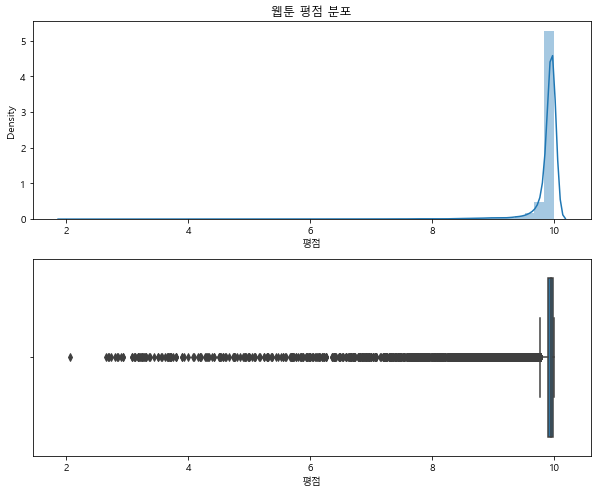

In [171]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(2,1,1)
sns.distplot(df['평점'])
plt.title('웹툰 평점 분포')

ax2 = plt.subplot(2,1,2,sharex = ax1)
sns.boxplot(df['평점'])
plt.show()

In [178]:
# Q3 = 9.97, Q1 = 9.89, mean = 9.84
# 전체 회차 중 75%가 평점 9.89 이상
# boxplot의 왼쪽 수염 경계값 = 9.77
# 평점이 경계값 미만인 회차는 총 3693개
# 해당 회차들의 리뷰를 크롤링하여 텍스트분석 및 감정분석 실행

Q3 = df['평점'].describe()['75%']
Mean = round(df['평점'].describe()['mean'],2)
Q1 = df['평점'].describe()['25%']
IQR = Q3 - Q1
Minimum = Q1 - 1.5 * IQR
under_minimum = len(df[df['평점']<Minimum])

print('Q3 : ',Q3)
print('Q1 : ',Q1)
print('Mean : ',Mean)
print('Minimum : ',Minimum)
print('under_mininum : ',under_minimum)

Q3 :  9.97
Q1 :  9.89
Mean :  9.84
Minimum :  9.77
under_mininum :  3693


## 회차별 댓글 크롤링

In [299]:
low_score = df[df['평점']<Minimum].reset_index(drop=True)
low_score['리뷰'] = ''

In [ ]:
for idx,episode in tqdm(enumerate(low_score['회차'])):
    webtoon_url = low_score['링크'][idx]
    webtoon_id = p.findall(webtoon_url)[0]
    episode_num = p.findall(webtoon_url)[1]
    comment_url = 'https://comic.naver.com/comment/comment?titleId={}&no={}'.format(webtoon_id,episode_num)
    browser.get(comment_url)
    time.sleep(0.3)
    
    html = browser.page_source
    soup = BeautifulSoup(html,'html.parser')
    best_comment = [comment.text for comment in soup.select('span.u_cbox_contents')]
    
    low_score.loc[idx,'리뷰'] = str(best_comment)
    print(best_comment)
    
    

In [34]:
# 작은따옴표(''), 폭 없는 공백(\\u200b) 제거
for idx, text in enumerate(low_score['리뷰']):
    table = str.maketrans('\'\\u200b[]','         ')
    low_score.loc[idx,'리뷰'] = text.translate(table)

In [39]:
low_score.to_csv('회차별리뷰.csv',index=False)

In [10]:
df = pd.read_csv('회차별리뷰.csv')

In [13]:
# 한글, 영어, 숫자, 공백 제외 문자 제거
for idx, review in enumerate(df['리뷰']):
    df.loc[idx,'리뷰'] = re.sub('[^가-힣0-9a-zA-z ]','',review)
    

In [ ]:
# 반복문자열 제거 -> 수정 필요
# q = re.compile(r'(.+)\1')
# for episode in df['리뷰']:
#     for review in episode.split(','):
#         q.findall(review)
        

In [14]:
# 전체 리뷰 문자열 생성
text = ''
for review in df['리뷰'] :
    text +=' ' + review

In [15]:
# 한국어 불용어 리스트 생성
# 출처 : https://www.ranks.nl/stopwords/korean

stop_words = ['작가','웹툰','진짜','지금','하는데','네이버','한번','사람','해서','갑자기','아니고','안','아니라','그냥','정말',
             '이제','같은','이건','듯','하는','하고','때문','가지','마음','입니다','솔직히','뭔가','한다','같은데','정도','보고',
             '되는','자체','보면','있는','하면','계속','오늘','없는','합니다','하지','아님','했는데','해도','건가','같음','하는거',
             '요즘','있는데','엄마','위해','그런','없고','나중','아니냐','생각']
with open('한국어_불용어.txt','r',encoding='utf-8') as f:
    for line in f:
        word = re.sub('\n','',line)
        stop_words.append(word)

In [16]:
# 형태소 분리
# 불용어 포함 단어, 1글자 단어 제외
# 명사, 동사, 형용사만 추출
okt = Okt()
words = [token for token, pos in okt.pos(text) if (pos in ['Noun','Verb','Adjective'])  & (token not in stop_words) & (len(token) > 1)]

In [18]:
# 단어 빈도 딕셔너리
word_counts ={}
for word in words:
    word_counts[word] = word_counts.get(word,0)+1

In [20]:
# 빈도수 상위 20개 단어 추출
import operator

sorted(word_counts.items(), key=operator.itemgetter(1), reverse = True)[:20]

[('스토리', 2963),
 ('표절', 2871),
 ('그림', 1803),
 ('주인공', 1734),
 ('댓글', 1700),
 ('내용', 1665),
 ('만화', 1577),
 ('독자', 1542),
 ('작품', 1440),
 ('쿠키', 1320),
 ('전개', 1306),
 ('베댓', 1193),
 ('분량', 1139),
 ('이유', 1006),
 ('여주', 978),
 ('여자', 946),
 ('이해', 932),
 ('친구', 923),
 ('처음', 898),
 ('남자', 891)]

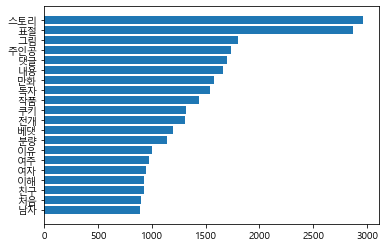

In [21]:
# 단어 빈도 시각화 - 막대그래프

n,w= zip(*sorted(word_counts.items(), key=operator.itemgetter(1), reverse = True)[:20])
plt.barh(range(len(n)),w,tick_label=n)
plt.gca().invert_yaxis()
plt.show()

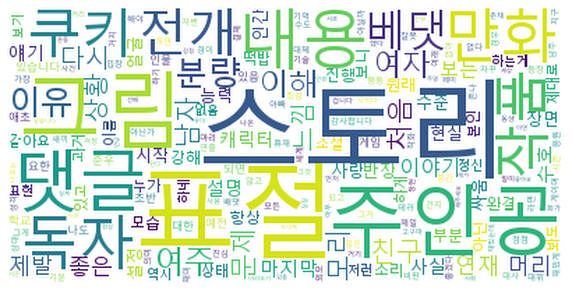

In [22]:
# 단어 빈도 시각화 - 워드 클라우드
wordcloud = WordCloud(font_path="c:/Windows/Fonts/malgun.ttf", background_color='white').generate_from_frequencies(word_counts)


plt.figure(figsize=(10,8)) #이미지 사이즈 지정
plt.imshow(wordcloud, interpolation='lanczos') #이미지의 부드럽기 정도
plt.axis('off') #x y 축 숫자 제거
plt.show() 